- Compute semantic similarity between abstracts and phase descriptions (from phase_desc.json)
- Combine similarity with query-based priors to assign phases
- Analyze phase distributions and confidence

Results:
- Semantic phase probabilities are generally low and close together → weak semantic separation
- Phase 3 (Optimization) becomes dominant for most abstracts
- Query-based priors strongly influence the final phase assignment, since the semantic separation is so weak.

Regarding the results:
- This is not necessarily wrong (that most ML-for-manufacturing research focuses on optimization)
- However, clearer and more detailed phase descriptions are likely needed
- A bibliometric clustering step should also be introduced before lifecycle phase mapping to reveal natural topic structure in the literature

In [1]:
# Imports

import json
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
processed_abstracts_path = Path("../../data/processed/abstracts")
phase_config_path = Path("../../phases/phase_desc.json")
save_path = processed_abstracts_path / "semantic_analysis"


# Ensure directories exist
for p in [data_path, processed_abstracts_path, save_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")


All directories verified/created.


In [12]:
# Load abstracts dataset

abstracts_path = processed_abstracts_path / "abstracts.csv"
df = pd.read_csv(abstracts_path)

print(f"Loaded {len(df)} abstracts from {df['query_id'].nunique()} queries.")
df.head()

Loaded 44071 abstracts from 19 queries.


,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S..."
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S..."
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,2025.The critical necessity for sophisticated ...
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,© 2025 The AuthorsThe Border Gateway Protocol ...


In [13]:
# Load phase descriptions from JSON

with phase_config_path.open("r", encoding="utf-8") as f:
    phases = json.load(f)

phase_ids = list(phases.keys())
phase_texts = [phases[p]["description"] for p in phase_ids]

for pid, ptext in zip(phase_ids, phase_texts):
    print(f"{pid}: {ptext[:80]}...")


phase_1: Work on early product or production planning: market and demand analysis, produc...
phase_2: Work on designing and developing products or running production processes: proce...
phase_3: Work on improving existing processes or systems using collected data: monitoring...
phase_4: Work on how products are used in the field or reused: in-service monitoring, usa...


In [34]:
# Phase priors per query_id
# Format: [Phase1_Planning, Phase2_Development/Production, Phase3_Optimization, Phase4_Use/Reuse]

phase_priors = {
    # Use / Reuse — dominant Phase 4
    "ml_inservice_monitoring":       [0.05, 0.20, 0.35, 0.40],
    "ml_remanufacturing":            [0.05, 0.10, 0.15, 0.70],
    "ml_disassembly":                [0.05, 0.25, 0.20, 0.50],
    "ml_end_of_life":                [0.05, 0.10, 0.15, 0.70],
    "ml_recycling_manufacturing":    [0.05, 0.30, 0.20, 0.45],
    "ml_sustainability_product":     [0.30, 0.10, 0.10, 0.50],

    # Very broad — spans production & optimization
    "ml_manufacturing":              [0.10, 0.45, 0.40, 0.05],

    # Planning phase focus
    "ml_planning_production":        [0.75, 0.15, 0.10, 0.00],
    "ml_product_design":             [0.80, 0.15, 0.05, 0.00],
    "ml_plm":                        [0.40, 0.10, 0.15, 0.35],  # lifecycle both ends

    # Development / Production execution focus
    "ml_product_development":        [0.20, 0.60, 0.20, 0.00],
    "ml_defect_detection":           [0.10, 0.65, 0.25, 0.00],
    "ml_quality_control":            [0.05, 0.55, 0.40, 0.00],
    "ml_automation":                 [0.05, 0.70, 0.25, 0.00],
    "ml_robotics_production":        [0.05, 0.75, 0.20, 0.00],

    # Supply chain → planning weighted, but still operational relevance
    "ml_supply_chain":               [0.45, 0.35, 0.15, 0.05],

    # Optimization focused
    "ml_manufacturing_optimization": [0.05, 0.25, 0.70, 0.00],
    "ml_production_optimization":    [0.05, 0.25, 0.70, 0.00],
    "ml_process_optimization":       [0.05, 0.25, 0.70, 0.00],
    "ml_process_control":            [0.05, 0.20, 0.75, 0.00],
    "ml_process_modeling":           [0.10, 0.20, 0.70, 0.00],
    "ml_predictive_maintenance":     [0.05, 0.20, 0.60, 0.15],
    "ml_anomaly_detection_production":[0.05, 0.20, 0.70, 0.05],

    # Use / Reuse specific — RUL informs lifetime while still in operation
    "ml_rul":                        [0.05, 0.15, 0.30, 0.50],
}



def get_phase_prior(query_id):
    # Return a valid probability vector for the query
    prior = phase_priors.get(query_id)
    if prior is None:
        # Default weakly uniform prior if unknown query_id
        prior = np.array([0.25, 0.25, 0.25, 0.25], dtype=float)
    else:
        prior = np.array(prior, dtype=float)
        prior = prior / prior.sum()
    return prior


In [35]:
# Define embedding and similarity helpers (to be implemented with your chosen model)

model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")  # In use
light_model = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2")

def get_embedding(text):
    """
    Return a vector embedding for the given text.
    Uses a SentenceTransformer model.
    """
    if not isinstance(text, str):
        text = ""
    emb = model.encode(
        text,
        show_progress_bar=False,
        convert_to_numpy=True,
        normalize_embeddings=True,
    )
    return emb

def cosine_similarity(a, b):
    # Compute cosine similarity between two 1D vectors
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)


In [36]:
# Precompute embeddings for all phase descriptions

phase_embeddings = []
for pid, ptext in zip(phase_ids, phase_texts):
    emb = get_embedding(ptext)
    phase_embeddings.append(emb)

phase_embeddings = np.vstack(phase_embeddings)
phase_embeddings.shape


(4, 768)

In [37]:
# Compute semantic phase scores for each abstract with progress bar

from tqdm import tqdm

sim_cols = ["sim_phase_1", "sim_phase_2", "sim_phase_3", "sim_phase_4"]

# Initialize columns
for col in sim_cols:
    df[col] = np.nan

batch_size = 512  # Adjust based on GPU memory

for start in tqdm(range(0, len(df), batch_size), desc="Embedding abstracts"):
    end = min(start + batch_size, len(df))
    batch = df.iloc[start:end]

    sims = []
    for text in batch["clean_abs"].astype(str).tolist():
        e_abs = get_embedding(text)
        sim_vec = [cosine_similarity(e_abs, pe) for pe in phase_embeddings]
        sims.append(sim_vec)

    sims = np.array(sims)
    exp_sims = np.exp(sims - sims.max(axis=1, keepdims=True))
    probs = exp_sims / exp_sims.sum(axis=1, keepdims=True)

    df.loc[batch.index, sim_cols] = probs

print("Semantic phase scores computed.")
df[sim_cols].head()


Embedding abstracts: 100%|██████████| 87/87 [08:31<00:00,  5.88s/it]

Semantic phase scores computed.


,sim_phase_1,sim_phase_2,sim_phase_3,sim_phase_4
0,0.224700,0.225181,0.329057,0.221062
1,0.237885,0.237330,0.283072,0.241714
2,0.244333,0.244594,0.275772,0.235301
3,0.234557,0.229667,0.282525,0.253251
4,0.235982,0.237986,0.296282,0.229749


In [45]:
# Combine query priors and semantic scores into final phase probabilities

alpha = 0.0 # Weight on priors (0=only semantics, 1=only priors)

final_cols = ["phase_p1", "phase_p2", "phase_p3", "phase_p4"]
df[final_cols] = np.nan

primary_labels = []
secondary_labels = []

for idx, row in df.iterrows():
    prior = get_phase_prior(row["query_id"])
    sem = row[sim_cols].values.astype(float)

    # Safety check for NaN
    if np.any(~np.isfinite(sem)):
        sem = np.ones(4) / 4.0

    combined = alpha * prior + (1 - alpha) * sem
    combined = combined / combined.sum()

    df.loc[idx, final_cols] = combined

    # Determine primary and secondary phases
    order = np.argsort(-combined)  # descending
    primary = order[0] + 1  # 1-based phase index
    secondary = order[1] + 1

    primary_labels.append(primary)
    secondary_labels.append(secondary)

df["primary_phase"] = primary_labels
df["secondary_phase"] = secondary_labels

print("Final phase probabilities and labels added.")
df[["query_id", "primary_phase", "secondary_phase"] + final_cols].head()


Final phase probabilities and labels added.


,query_id,primary_phase,secondary_phase,phase_p1,phase_p2,phase_p3,phase_p4
0,ml_anomaly_detection_production,3,2,0.224700,0.225181,0.329057,0.221062
1,ml_anomaly_detection_production,3,4,0.237885,0.237330,0.283072,0.241714
2,ml_anomaly_detection_production,3,2,0.244333,0.244594,0.275772,0.235301
3,ml_anomaly_detection_production,3,4,0.234557,0.229667,0.282525,0.253251
4,ml_anomaly_detection_production,3,2,0.235982,0.237986,0.296282,0.229749


In [ ]:
# Save extended dataset with phase information

out_path = save_path / "abstracts_with_phases.csv"
df.to_csv(out_path, index=False)
print(f"Saved dataset with phases to: {out_path}")


Saved dataset with phases to: ../../data/processed/abstracts/abstracts_with_phases.csv


primary_phase
1     6246
2     2995
3    31184
4     3646
Name: count, dtype: int64


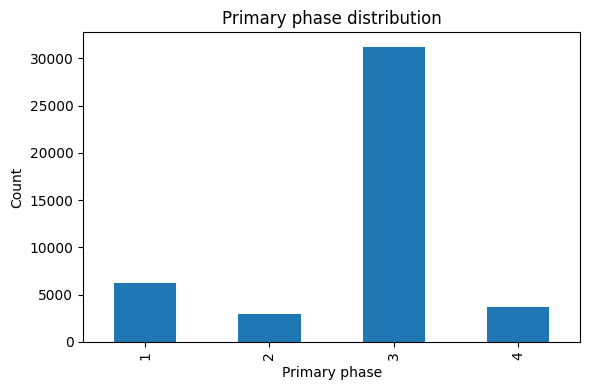

In [ ]:
# Plot primary phase distribution

phase_counts = df["primary_phase"].value_counts().sort_index()
print(phase_counts)

plt.figure(figsize=(6,4))
phase_counts.plot(kind="bar")
plt.xlabel("Primary phase")
plt.ylabel("Count")
plt.title("Primary phase distribution")
plt.tight_layout()
plt.show()


In [48]:
# Inspect phase distribution per query_id

phase_query_ct = pd.crosstab(df["query_id"], df["primary_phase"], normalize="index")
phase_query_ct = phase_query_ct.rename(columns=lambda x: f"phase_{x}")

phase_query_ct.head()


primary_phase,phase_1,phase_2,phase_3,phase_4
query_id,,,,
ml_anomaly_detection_production,0.002841,0.002841,0.981534,0.012784
ml_disassembly,0.089021,0.160237,0.584570,0.166172
ml_end_of_life,0.019608,0.000000,0.274510,0.705882
ml_inservice_monitoring,0.031798,0.024123,0.868421,0.075658
ml_manufacturing,0.159402,0.105053,0.655785,0.079760


In [49]:
# Show queries most dominated by each phase

for p in [1, 2, 3, 4]:
    col = f"phase_{p}"
    print(f"\nTop queries for {col}:")
    display(phase_query_ct[col].sort_values(ascending=False).head(10))



Top queries for phase_1:


query_id
ml_supply_chain               0.322684
ml_planning_production        0.311082
ml_product_design             0.255167
ml_product_development        0.227991
ml_production_optimization    0.175644
ml_manufacturing              0.159402
ml_remanufacturing            0.153846
ml_sustainability_product     0.133789
ml_robotics_production        0.119678
ml_plm                        0.111111
Name: phase_1, dtype: float64


Top queries for phase_2:


query_id
ml_robotics_production    0.311853
ml_disassembly            0.160237
ml_manufacturing          0.105053
ml_product_design         0.069138
ml_process_control        0.067299
ml_product_development    0.063205
ml_remanufacturing        0.061538
ml_plm                    0.055556
ml_supply_chain           0.048988
ml_process_modeling       0.042328
Name: phase_2, dtype: float64


Top queries for phase_3:


query_id
ml_anomaly_detection_production    0.981534
ml_rul                             0.971024
ml_predictive_maintenance          0.953955
ml_inservice_monitoring            0.868421
ml_process_control                 0.851025
ml_process_modeling                0.830688
ml_plm                             0.742063
ml_production_optimization         0.739040
ml_manufacturing                   0.655785
ml_planning_production             0.596422
Name: phase_3, dtype: float64


Top queries for phase_4:


query_id
ml_end_of_life                0.705882
ml_recycling_manufacturing    0.652893
ml_sustainability_product     0.438477
ml_remanufacturing            0.438462
ml_product_design             0.228083
ml_supply_chain               0.198083
ml_disassembly                0.166172
ml_product_development        0.155756
ml_robotics_production        0.147296
ml_plm                        0.091270
Name: phase_4, dtype: float64

In [50]:
# Compute confidence metrics for phase assignment

df["phase_max_prob"] = df[["phase_p1", "phase_p2", "phase_p3", "phase_p4"]].max(axis=1)

# Gap between primary and secondary phases
sorted_probs = np.sort(df[["phase_p1", "phase_p2", "phase_p3", "phase_p4"]].values, axis=1)
df["phase_margin"] = sorted_probs[:, -1] - sorted_probs[:, -2]

df[["primary_phase", "secondary_phase", "phase_max_prob", "phase_margin"]].describe()


,primary_phase,secondary_phase,phase_max_prob,phase_margin
count,44071.000000,44071.000000,44071.000000,4.407100e+04
mean,2.731320,2.278369,0.273230,2.201098e-02
std,0.803379,1.192414,0.013227,1.826067e-02
min,1.000000,1.000000,0.250514,7.509514e-07
25%,3.000000,1.000000,0.262886,7.094942e-03
50%,3.000000,2.000000,0.270653,1.736391e-02
75%,3.000000,3.000000,0.281483,3.317818e-02
max,4.000000,4.000000,0.332371,1.040271e-01


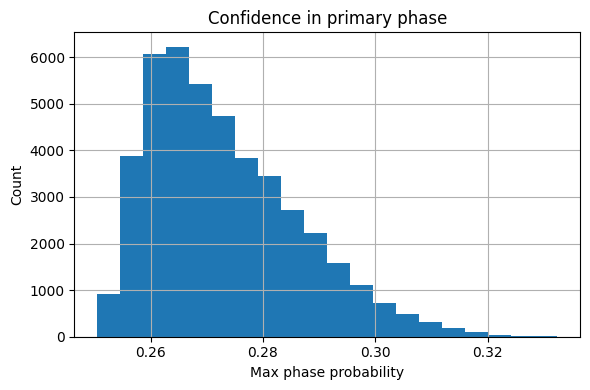

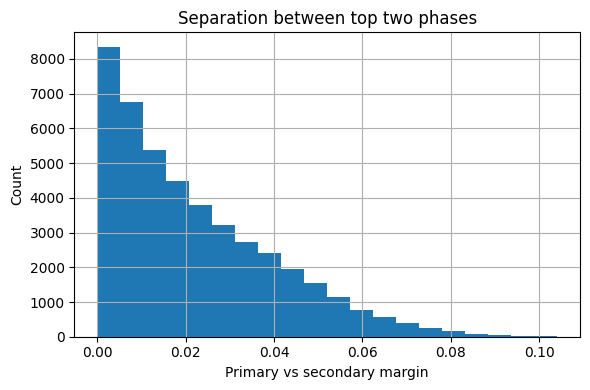

In [51]:
# Plot distributions of confidence and margin

plt.figure(figsize=(6,4))
df["phase_max_prob"].hist(bins=20)
plt.xlabel("Max phase probability")
plt.ylabel("Count")
plt.title("Confidence in primary phase")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
df["phase_margin"].hist(bins=20)
plt.xlabel("Primary vs secondary margin")
plt.ylabel("Count")
plt.title("Separation between top two phases")
plt.tight_layout()
plt.show()


In [53]:
# Inspect low-confidence samples

low_conf_mask = df["phase_max_prob"] < 0.5
print(f"Low-confidence abstracts (<0.5): {low_conf_mask.sum()}")

df_low_conf = df[low_conf_mask].sort_values("phase_max_prob").head(20)
df_low_conf[[
    "query_id",
    "doi",
    "primary_phase",
    "secondary_phase",
    "phase_p1",
    "phase_p2",
    "phase_p3",
    "phase_p4",
    "clean_abs"
]]


Low-confidence abstracts (<0.5): 44071


,query_id,doi,primary_phase,secondary_phase,phase_p1,phase_p2,phase_p3,phase_p4,clean_abs
3646,ml_manufacturing,10.1016/j.technovation.2025.103230,1,2,0.250514,0.250019,0.249971,0.249496,© 2025The advent of Industry 4.0 technologies ...
5937,ml_manufacturing,10.1016/j.nxnano.2024.100115,4,2,0.250048,0.250081,0.249221,0.250650,© 2024 The AuthorsWith advances in liquid cell...
17597,ml_manufacturing,10.1117/12.2524915,4,3,0.249384,0.249687,0.250249,0.250680,© COPYRIGHT SPIE. Downloading of the abstract ...
34943,ml_production_optimization,10.3788/CJL231577,2,3,0.248753,0.250715,0.250282,0.250250,© 2024 Science Press. All rights reserved.Sign...
7080,ml_manufacturing,10.3788/CJL231577,2,3,0.248753,0.250715,0.250282,0.250250,© 2024 Science Press. All rights reserved.Sign...
3573,ml_manufacturing,10.3390/pharmaceutics17050568,2,3,0.249994,0.250787,0.250627,0.248591,© 2025 by the authors.Objectives: Hot-melt ext...
33228,ml_production_optimization,10.3390/pharmaceutics17050568,2,3,0.249994,0.250787,0.250627,0.248591,© 2025 by the authors.Objectives: Hot-melt ext...
1779,ml_inservice_monitoring,10.1007/s11661-020-05888-w,1,2,0.250818,0.250259,0.248669,0.250254,"© 2020, The Minerals, Metals & Materials Socie..."
16666,ml_manufacturing,10.1115/IMECE2020-23231,3,2,0.250138,0.250406,0.250820,0.248635,. This is an Open Access article under the CC ...
17431,ml_manufacturing,10.3390/sym11020244,2,3,0.248508,0.250900,0.250824,0.249768,© 2019 by the authors.After the emergence of t...


In [54]:
# Aggregate mean phase probabilities per query_id

phase_prob_cols = ["phase_p1", "phase_p2", "phase_p3", "phase_p4"]
query_phase_means = df.groupby("query_id")[phase_prob_cols].mean()

query_phase_means.head()


,phase_p1,phase_p2,phase_p3,phase_p4
query_id,,,,
ml_anomaly_detection_production,0.235875,0.238329,0.292915,0.232880
ml_disassembly,0.243774,0.246731,0.261920,0.247575
ml_end_of_life,0.243040,0.231089,0.253305,0.272566
ml_inservice_monitoring,0.241109,0.238359,0.274644,0.245887
ml_manufacturing,0.248312,0.245964,0.264841,0.240883


In [55]:
# Show queries with highest mean probability for each phase

for i, col in enumerate(phase_prob_cols, start=1):
    print(f"\nTop queries by mean {col}:")
    display(query_phase_means[col].sort_values(ascending=False).head(10))



Top queries by mean phase_p1:


query_id
ml_planning_production        0.257381
ml_supply_chain               0.254587
ml_production_optimization    0.252487
ml_product_design             0.250606
ml_product_development        0.250013
ml_sustainability_product     0.248999
ml_manufacturing              0.248312
ml_robotics_production        0.247925
ml_process_modeling           0.247257
ml_plm                        0.247243
Name: phase_p1, dtype: float64


Top queries by mean phase_p2:


query_id
ml_robotics_production        0.252526
ml_disassembly                0.246731
ml_manufacturing              0.245964
ml_process_control            0.245024
ml_product_design             0.244199
ml_process_modeling           0.243212
ml_plm                        0.243195
ml_product_development        0.242432
ml_remanufacturing            0.240666
ml_recycling_manufacturing    0.239836
Name: phase_p2, dtype: float64


Top queries by mean phase_p3:


query_id
ml_anomaly_detection_production    0.292915
ml_predictive_maintenance          0.283650
ml_rul                             0.281904
ml_process_control                 0.276639
ml_inservice_monitoring            0.274644
ml_process_modeling                0.274201
ml_production_optimization         0.269013
ml_plm                             0.264944
ml_planning_production             0.264866
ml_manufacturing                   0.264841
Name: phase_p3, dtype: float64


Top queries by mean phase_p4:


query_id
ml_end_of_life                0.272566
ml_recycling_manufacturing    0.264788
ml_sustainability_product     0.258166
ml_remanufacturing            0.257921
ml_rul                        0.249207
ml_product_design             0.248808
ml_product_development        0.247634
ml_disassembly                0.247575
ml_supply_chain               0.247190
ml_inservice_monitoring       0.245887
Name: phase_p4, dtype: float64

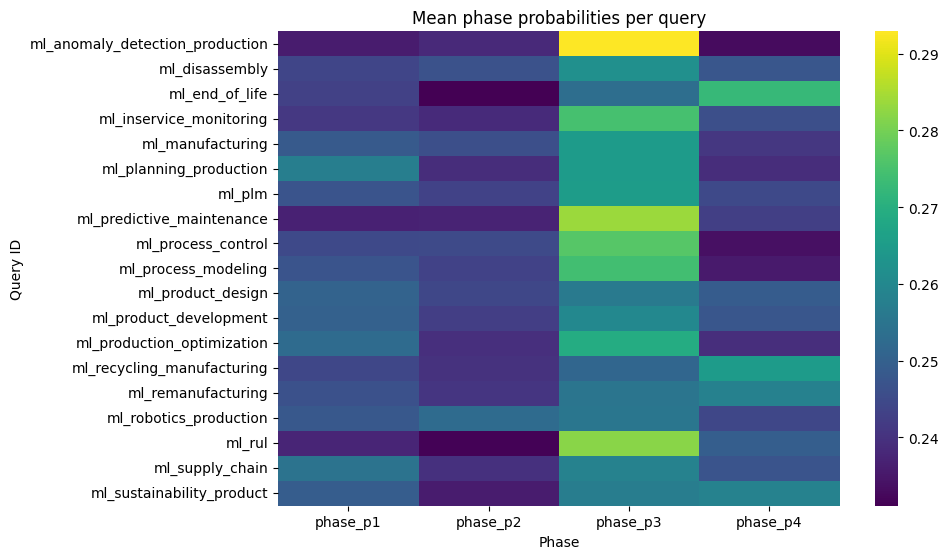

In [57]:
# Plot heatmap of mean phase probabilities per query_id

import seaborn as sns  # if you are OK adding seaborn

plt.figure(figsize=(10, len(query_phase_means) * 0.3))
sns.heatmap(
    query_phase_means[phase_prob_cols],
    annot=False,
    cmap="viridis",
    cbar=True
)
plt.xlabel("Phase")
plt.ylabel("Query ID")
plt.title("Mean phase probabilities per query")
plt.tight_layout()
plt.show()


In [60]:
# Show the most confident abstracts for each phase (primary_phase)
cols_show = [
    "query_id", "doi", "primary_phase", "phase_max_prob", "phase_margin",
    "title", "clean_abs"
]

for p in [1, 2, 3, 4]:
    print(f"\nMost confident Phase {p} abstracts\n")
    
    df_phase = df[df["primary_phase"] == p]
    top_conf = df_phase.sort_values("phase_max_prob", ascending=False).head(5)
    
    display(top_conf[cols_show])



Most confident Phase 1 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
38505,ml_production_optimization,10.1109/SMC42975.2020.9282869,1,0.299777,0.040922,Neural Combinatorial Optimization for Producti...,© 2020 IEEE.One of the main objectives of prod...
16107,ml_manufacturing,10.1109/SMC42975.2020.9282869,1,0.299777,0.040922,Neural Combinatorial Optimization for Producti...,© 2020 IEEE.One of the main objectives of prod...
20845,ml_planning_production,10.1109/SMC42975.2020.9282869,1,0.299777,0.040922,Neural Combinatorial Optimization for Producti...,© 2020 IEEE.One of the main objectives of prod...
20485,ml_planning_production,10.1016/j.ifacol.2022.09.305,1,0.298265,0.050405,Predicting makespan in Flexible Job Shop Sched...,© 2022 The Authors. This is an open access art...
19309,ml_planning_production,10.1080/00207543.2025.2453651,1,0.297441,0.042169,A novel machine-learning rolling horizon heuri...,"© 2025 Informa UK Limited, trading as Taylor &..."



Most confident Phase 2 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
42878,ml_supply_chain,10.1016/j.tre.2021.102273,2,0.282618,0.007561,Novel robotic job-shop scheduling models with ...,© 2021 Elsevier LtdThe robotic job-shop schedu...
40324,ml_robotics_production,10.1016/j.tre.2021.102273,2,0.282618,0.007561,Novel robotic job-shop scheduling models with ...,© 2021 Elsevier LtdThe robotic job-shop schedu...
20697,ml_planning_production,10.1016/j.tre.2021.102273,2,0.282618,0.007561,Novel robotic job-shop scheduling models with ...,© 2021 Elsevier LtdThe robotic job-shop schedu...
20842,ml_planning_production,10.1109/IROS45743.2020.9341666,2,0.282240,0.020445,Automatic synthesis of human motion from tempo...,© 2020 IEEE.Humans and robots are increasingly...
40390,ml_robotics_production,10.1109/IROS45743.2020.9341666,2,0.282240,0.020445,Automatic synthesis of human motion from tempo...,© 2020 IEEE.Humans and robots are increasingly...



Most confident Phase 3 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
18646,ml_manufacturing,10.1145/2184751.2184798,3,0.332371,0.100612,Application case study of machine learning tec...,Fault diagnosis is a vital problem in process ...
27602,ml_process_control,10.1109/ICCCS57501.2023.10150495,3,0.331043,0.101957,Anomaly Detection for Process Industry using C...,© 2023 IEEE.Anomaly detection is essential to ...
26072,ml_process_control,10.1016/j.engappai.2025.111227,3,0.331041,0.098063,Enhanced process monitoring using machine lear...,© 2025 Elsevier LtdThe ability to detect shift...
29050,ml_process_control,10.1109/CCDC.2011.5968820,3,0.330904,0.088347,An online outlier detection method for process...,The ability to detect outlier online in proces...
27093,ml_process_control,10.1145/3663369,3,0.330857,0.104027,Active Learning for Data Quality Control: A Su...,© 2024 Copyright held by the owner/author(s).D...



Most confident Phase 4 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
1046,ml_end_of_life,10.3390/su17125511,4,0.308250,0.068122,Review and Novel Framework with Hui–Walter Met...,© 2025 by the authors.Consumers’ growing inter...
43201,ml_sustainability_product,10.3390/su17125511,4,0.308250,0.068122,Review and Novel Framework with Hui–Walter Met...,© 2025 by the authors.Consumers’ growing inter...
42289,ml_supply_chain,10.1007/978-981-96-3939-7_6,4,0.306139,0.065326,Utilizing Machine Learning for Enhanced Produc...,", under exclusive license to Springer Nature S..."
19354,ml_planning_production,10.1007/978-981-96-3939-7_6,4,0.306139,0.065326,Utilizing Machine Learning for Enhanced Produc...,", under exclusive license to Springer Nature S..."
34404,ml_production_optimization,10.1038/s41598-024-81741-z,4,0.304617,0.061551,Stakeholder perspectives on the costs and bene...,2024.The construction industry significantly i...
